Convert JSON to CSV

In [ ]:
# Since google restaurant dataset is in json format, use pandas to convert it into a CSV file
# DO NOT RERUN
import pandas as pd 
df = pd.read_json(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.json', lines=True)
df.to_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv', index = None)

Formatting of Data

In [1]:
# Load in all three datasets
# .csv files use the utf-8 encodings
import pandas as pd

#amzn = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
#googl = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
#dis = pd.read_csv(r'E:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

amzn = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\AmazonReviews.csv',encoding='utf-8',engine='python')
googl = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\GoogleRestaurantReview.csv',encoding='utf-8',engine='python')
dis = pd.read_csv(r'C:\AIEBA Datasets\Proj1 Datasets\DisneylandReviews.csv',encoding='utf-8',engine='python')

In [ ]:
amzn.head()

In [ ]:
googl.head()

In [ ]:
dis.head()

In [2]:
# Drop columns that are not needed and standardize column names
amzn = amzn.filter(items=['reviews.rating', 'reviews.text'])
amzn = amzn.rename(columns={"reviews.rating":"reviews_rating", "reviews.text":"reviews_text"})

googl = googl.filter(items=['rating', 'review_text'])
googl = googl.rename(columns={"rating":"reviews_rating", "review_text":"reviews_text"})

dis = dis.filter(items=['Rating','Review_Text'])
dis = dis.rename(columns={"Rating":"reviews_rating", "Review_Text":"reviews_text"})

amzn.head()

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...


In [3]:
# Concatenate all 3 datasets by column
combined = pd.concat([amzn, googl, dis], ignore_index=True)
combined

,reviews_rating,reviews_text
0,5.0,This $product so far has not%&^# disappointed....
1,5.0,great for beginner or experienced person. Boug...
2,5.0,Inexpensive tablet for him to use and learn on...
3,4.0,I've had my Fire HD 8 two weeks now and I love...
4,5.0,I bought this for my grand daughter when she c...
...,...,...
1125886,5.0,i went to disneyland paris in july 03 and thou...
1125887,5.0,2 adults and 1 child of 11 visited Disneyland ...
1125888,5.0,My eleven year old daughter and myself went to...
1125889,4.0,"This hotel, part of the Disneyland Paris compl..."


Data Cleansing and preprocessing

In [4]:
# remove rows with missing values
print(combined.isnull().sum())
combined = combined.dropna()

reviews_rating    55
reviews_text      16
dtype: int64


In [5]:
#missing values removed 
print(combined.isnull().sum())

reviews_rating    0
reviews_text      0
dtype: int64


In [ ]:
combined["reviews_rating"].value_counts().plot.bar()
combined["reviews_rating"].value_counts(ascending=True)

,reviews_rating,reviews_text
767720,5.0,"Brought a bus load of 32 in, Dave answered the..."
667366,5.0,One of the most memorable dining experiences i...
520376,5.0,Excellent place for breakfast lunch and dinner...
731701,5.0,Always a great place for breakfast
943168,5.0,Tasty & Juicy Classic burger. Friendly staff. ...
...,...,...
822912,1.0,Terrible. Place got so overpriced. Selling 12o...
769163,1.0,"We came for happy hour, my first margarita the..."
566524,1.0,On January 14 at 5:45 PM I ordered this meal. ...
456905,1.0,Horrible drive thru service. 27 minutes and co...


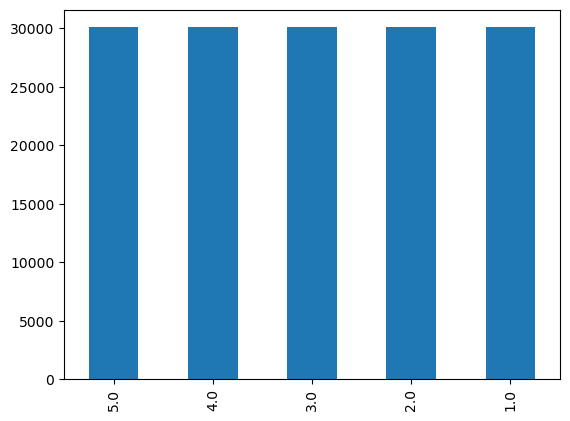

In [6]:
# perform undersampling to get balanced dataset

least_class_amount, class_1, class_3, class_4, class_5 = combined.reviews_rating.value_counts(ascending=True)

# create separate dataframes for each rating
c5 = combined[combined["reviews_rating"] == 5.0]
c4 = combined[combined["reviews_rating"] == 4.0]
c3 = combined[combined["reviews_rating"] == 3.0]
c2 = combined[combined["reviews_rating"] == 2.0]
c1 = combined[combined["reviews_rating"] == 1.0]

# randomly remove data to in each dataframe to match the number of rows in c2 which has the least amount of data
df_5 = c5.sample(least_class_amount, random_state=100)
df_4 = c4.sample(least_class_amount, random_state=100)
df_3 = c3.sample(least_class_amount, random_state=100)
df_1 = c1.sample(least_class_amount, random_state=100)

# concatenate all 5 dataframes into 1
undersampled = pd.concat([df_5, df_4, df_3, c2, df_1], axis=0)
combined = undersampled
combined.reviews_rating.value_counts().plot.bar()
combined.reviews_rating.value_counts()
combined

In [7]:
# remove non-ascii characters
combined["reviews_text"] = combined["reviews_text"].str.encode('ascii', 'ignore').str.decode('ascii')

In [8]:
# using regular expressions to remove unwanted characters and punctuations
import re

def cleanup(sentence):
  sentence = str(sentence).lower()
  sentence = cleanup_re.sub('',sentence).strip() 
  sentence = re.sub('[\d]','',sentence) # remove all digits and numbers
  return sentence
  
cleanup_re = re.compile('[^\w\s]') # match whitespaces words only
combined["reviews_text"] = combined["reviews_text"].apply(cleanup)
combined

,reviews_rating,reviews_text
767720,5.0,brought a bus load of in dave answered the ph...
667366,5.0,one of the most memorable dining experiences i...
520376,5.0,excellent place for breakfast lunch and dinner...
731701,5.0,always a great place for breakfast
943168,5.0,tasty juicy classic burger friendly staff goo...
...,...,...
822912,1.0,terrible place got so overpriced selling oz so...
769163,1.0,we came for happy hour my first margarita ther...
566524,1.0,on january at pm i ordered this meal i menti...
456905,1.0,horrible drive thru service minutes and counting


In [9]:
# remove stopwords 
import nltk
from nltk.corpus import stopwords

def remove_stopwords(sentence):
  sentence = sentence.split()
  sentence = [word for word in sentence if word not in stoplist]
  sentence = ' '.join(sentence)
  return sentence
    

def custom_stoplist():
  stop_words = set(stopwords.words('english'))
  wanted_stopwords = {'not', 'nor', 'no', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'very'} # stopwords that can change a sentence's meaning
  stoplist = stop_words - wanted_stopwords
  return stoplist

stoplist = custom_stoplist()
combined["reviews_text"] = combined["reviews_text"].apply(remove_stopwords)
combined

,reviews_rating,reviews_text
767720,5.0,brought bus load dave answered phone minutes g...
667366,5.0,one memorable dining experiences austin many d...
520376,5.0,excellent place breakfast lunch dinner would h...
731701,5.0,always great place breakfast
943168,5.0,tasty juicy classic burger friendly staff good...
...,...,...
822912,1.0,terrible place got overpriced selling oz soup ...
769163,1.0,came happy hour first margarita no alcohol sis...
566524,1.0,january pm ordered meal mentioned people pleas...
456905,1.0,horrible drive thru service minutes counting


In [ ]:
combined["reviews_rating"].value_counts().plot.bar()
combined["reviews_rating"].value_counts(ascending=True)

In [10]:
# perform 80-20 split on data
from sklearn.model_selection import train_test_split
train, test = train_test_split(combined, test_size=0.2, train_size=0.8, random_state=100) 
# random_state controls how data is being shuffled
# ensures that data is being shuffled the same way every time the cell is being ran
train


,reviews_rating,reviews_text
1020326,1.0,horrible rude service sat mins waitress never ...
810795,1.0,sonic supposed fast location slowest serving l...
1012916,5.0,great brunch place view
693067,1.0,super duper slow app sucks triggered
122049,3.0,customer service excellent tacos little greasy...
...,...,...
523613,3.0,absolutely loved hoagie oil everything fryed t...
317484,3.0,neat ambiance overall fries great burger absol...
822956,3.0,attention great food stunninghowever got table...
1005814,4.0,youre looking gluten free dairy free healthier...


Constructing the model

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


def remove_stopwords():
  import nltk
  from nltk.corpus import stopwords
  stop_words = set(stopwords.words('english'))
  print(stop_words)


training_sentences = train["reviews_text"].tolist()
training_labels = train["reviews_rating"].tolist()
test_sentences = test["reviews_text"].tolist()
test_labels = test["reviews_rating"].tolist()
vocab_size = 20000 # number of words that will be fed into model 
max_length = 100 #
trunc_type='post' # 
padding_type='post' #
oov_tok = "<OOV>" # placeholder if model encounters words it has never seen before in the test set

# Tokenization - breaking down sentences into its individual words and assigning a number to it
tokenizer = Tokenizer(num_words=vocab_size, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index # Model's 'vocabulary' learnt from training data

# Sequencing - converting each sentence into its numerical equivalent
# Padding and truncating used to make all sentences same length 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type,
                               truncating=trunc_type)

In [ ]:
tokenizer.word_docs

In [ ]:
print(len(word_index))

In [12]:
# Need this block to get it to work with TensorFlow 2.x
training_padded = np.array(training_padded)
training_labels = tf.keras.utils.to_categorical(training_labels)
test_padded = np.array(test_padded)
test_labels = tf.keras.utils.to_categorical(test_labels)

Model Building

In [15]:
import keras
num_of_ratings = 6 # number of possible ratings given by users: 1 to 5
embeding_dim = 104
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, embeding_dim, input_length=max_length))
model.add(keras.layers.Conv1D(97,96,activation='relu'))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(80, activation='relu')) 
model.add(keras.layers.Dense(50, activation='relu')) 
model.add(keras.layers.Dense(num_of_ratings, activation='softmax'))                                                                        

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])


In [16]:
# Training model

#epochs_2 = 10
#prediction_2 = model.fit(training_padded, training_labels, epochs=epochs_2, validation_data=(test_padded, test_labels), verbose=2)

epochs_2 = 10
history = model.fit(training_padded, training_labels, epochs=epochs_2, validation_data=(test_padded, test_labels), verbose=2)


Epoch 1/10
3762/3762 - 250s - loss: 1.0556 - accuracy: 0.5281 - val_loss: 1.0065 - val_accuracy: 0.5526 - 250s/epoch - 66ms/step
Epoch 2/10
3762/3762 - 256s - loss: 0.8800 - accuracy: 0.6166 - val_loss: 1.0219 - val_accuracy: 0.5603 - 256s/epoch - 68ms/step
Epoch 3/10
3762/3762 - 253s - loss: 0.6669 - accuracy: 0.7178 - val_loss: 1.2611 - val_accuracy: 0.5409 - 253s/epoch - 67ms/step
Epoch 4/10
3762/3762 - 280s - loss: 0.4917 - accuracy: 0.7998 - val_loss: 1.6136 - val_accuracy: 0.5305 - 280s/epoch - 74ms/step
Epoch 5/10


KeyboardInterrupt: 

In [38]:
sentence = ["product took super long to come, not worth it"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
output= model.predict(padded)

print(output)
print("Review:", sentence)
print("Rating:", np.argmax(output, axis=None, out=None))

1/1 [==============================] - 0s 35ms/step
[[0.16460219 0.16290961 0.16867116 0.16665943 0.16749617 0.1696614 ]]
Review: ['product took super long to come, not worth it']
Rating: 5


In [ ]:
# Generating confusion matrix based on predictions 
# True is column, Pred is row 
pred = np.argmax(pred_prob, axis=1)
true = np.argmax(test_labels, axis=1)
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(true, pred, labels=[5,4,3,2,1])
print(confusion_m)